## overview

In [1]:
# default package
import logging
import sys 
import os
import pathlib
import IPython
import random
from urllib.request import urlretrieve

In [2]:
# third party package
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import pymc3 as pm
import seaborn as sns
import theano.tensor as T
import scipy.stats as stats
from scipy.stats.mstats import mquantiles
import arviz as az
import scipy.optimize as sop
from scipy.optimize import fmin

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# my package
sys.path.append(os.path.join(pathlib.Path().resolve(),"../"))

In [4]:
# reload settings
%load_ext autoreload
%autoreload 2

In [5]:
# logger
logger=logging.getLogger(__name__)
logging.basicConfig(level=logging.ERROR)

In [6]:
# graph setting
sns.set()

## The Price is Right

In [7]:
data_mu = [3e3, 12e3]
data_std =  [5e2, 3e3] 
mu_prior = 35e3
std_prior =  75e2

with pm.Model() as model:
    true_price = pm.Normal("true_price", mu=mu_prior, sd=std_prior)
    
    prize_1 = pm.Normal("first_prize", mu=data_mu[0], sd=data_std[0])
    prize_2 = pm.Normal("second_prize", mu=data_mu[1], sd=data_std[1])
    price_estimate = prize_1 + prize_2
    
    logp = pm.Normal.dist(mu=price_estimate, sd=(3e3)).logp(true_price)
    error = pm.Potential("error", logp)  #尤度を直接与えている？

    trace = pm.sample(50000, step=pm.Metropolis(),return_inferencedata=False)
    burned_trace = trace[10000:]

price_trace = burned_trace["true_price"]

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [second_prize]
INFO:pymc3:>Metropolis: [second_prize]
>Metropolis: [first_prize]
INFO:pymc3:>Metropolis: [first_prize]
>Metropolis: [true_price]
INFO:pymc3:>Metropolis: [true_price]


Sampling 4 chains for 1_000 tune and 50_000 draw iterations (4_000 + 200_000 draws total) took 35 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 50_000 draw iterations (4_000 + 200_000 draws total) took 35 seconds.
The number of effective samples is smaller than 10% for some parameters.


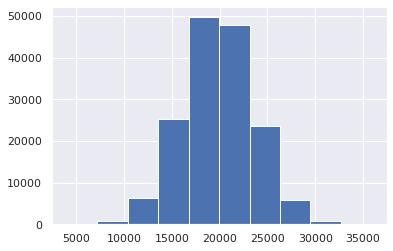

In [8]:
plt.hist(price_trace);

In [9]:
def showdown_loss(guess,true_price,risk=80000):
    loss=np.zeros_like(true_price)
    ix=true_price<guess
    loss[~ix]=np.abs(guess-true_price[~ix])
    close_mask = [abs(true_price - guess) <= 250]
    loss[tuple(close_mask)] = -2*true_price[tuple(close_mask)]
    loss[ix]=risk
    return loss

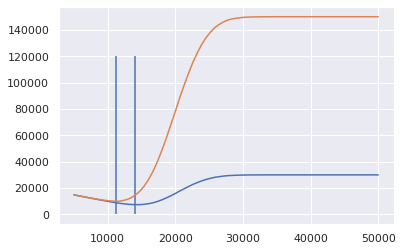

In [10]:
guesses = np.linspace(5000, 50000, 70) 
risks = np.linspace(30000, 150000, 2)
expected_loss = lambda guess, risk: \
    showdown_loss(guess, price_trace, risk).mean()
        
for _p in risks:
    _min_results = sop.fmin(expected_loss, 15000, args=(_p,),disp = False)
    plt.vlines(_min_results,0,120000)
    results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, results, label = "%d"%_p)

## 株価の予測

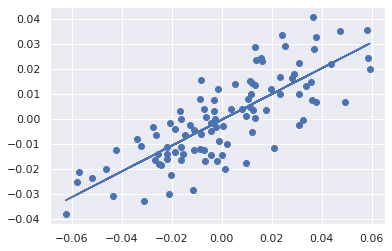

In [11]:
N = 100
X = 0.025*np.random.randn(N)
Y = 0.5*X + 0.01*np.random.randn(N) 
ls_coef_ = np.cov(X, Y)[0,1]/np.var(X)
ls_intercept = Y.mean() - ls_coef_*X.mean()

plt.scatter(X,Y);
plt.plot(X,X*ls_coef_+ls_intercept);

In [12]:
with pm.Model() as model:
    std=pm.Uniform("std",0,100)
    beta=pm.Normal("beta",mu=0,sd=100)
    alpha=pm.Normal("alpha",mu=0,sd=100)
    mean=pm.Deterministic("mean",alpha+beta*X)
    obs=pm.Normal("obs",mu=mean,sd=std,observed=Y)
    trace=pm.sample(100000,step=pm.Metropolis(),return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
INFO:pymc3:CompoundStep
>Metropolis: [alpha]
INFO:pymc3:>Metropolis: [alpha]
>Metropolis: [beta]
INFO:pymc3:>Metropolis: [beta]
>Metropolis: [std]
INFO:pymc3:>Metropolis: [std]


Sampling 4 chains for 1_000 tune and 100_000 draw iterations (4_000 + 400_000 draws total) took 74 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 100_000 draw iterations (4_000 + 400_000 draws total) took 74 seconds.
The number of effective samples is smaller than 10% for some parameters.


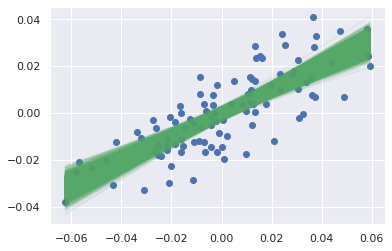

In [13]:
# 予測分布
alpha_samples=trace["alpha"][::100]
beta_samples=trace["beta"][::100]
std_samples=trace["std"][::100]
X_range = np.linspace(X.min(), X.max(), 50)
for i in range(len(alpha_samples)):
    pm_y = [alpha_samples[i] + beta_samples[i]*x for x in X_range]
    plt.plot(X_range, pm_y, 'g-', alpha=0.1)
plt.scatter(X,Y);

In [14]:
# ベイズ行動
def stock_loss(price, pred, coef = 500):
    """vectorized for numpy"""
    sol = np.zeros_like(price)
    ix = price*pred < 0 
    sol[ix] = coef*pred**2 - np.sign(price[ix])*pred + abs(price[ix])
    sol[~ix] = abs(price[~ix] - pred)
    return sol

In [15]:
alpha_samples=trace["alpha"]
beta_samples=trace["beta"]
std_samples=trace["std"]
N=alpha_samples.shape[0]
noise = std_samples*np.random.randn(N) 

def regression(x):
    y=alpha_samples+beta_samples*x+noise
    return y

action=np.zeros(50)
for idx,x in enumerate(np.linspace(X.min(),X.max(),50)):
    tomin=lambda pred:stock_loss(regression(x),pred).mean()
    action[idx]=fmin(tomin,0,disp=False)

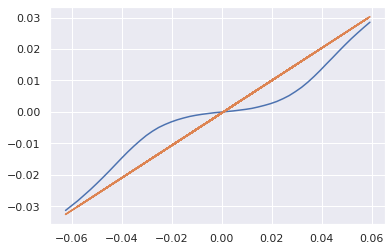

In [16]:
plt.plot(np.linspace(X.min(),X.max(),50),action)
plt.plot(X,X*ls_coef_+ls_intercept);

## ダークマター

In [17]:
os.makedirs("data/Train_Skies/Train_Skies",exist_ok=True)
urlretrieve("https://git.io/vXLqk","data/Train_Skies/Train_Skies/Training_Sky3.csv")
urlretrieve("https://git.io/vXLqU","draw_sky2.py")

('draw_sky2.py', <http.client.HTTPMessage at 0x7fc9ac468c40>)

Data on galaxies in sky 3.
position_x, position_y, e_1, e_2 
[[ 1.62690e+02  1.60006e+03  1.14664e-01 -1.90326e-01]
 [ 2.27228e+03  5.40040e+02  6.23555e-01  2.14979e-01]
 [ 3.55364e+03  2.69771e+03  2.83527e-01 -3.01870e-01]]


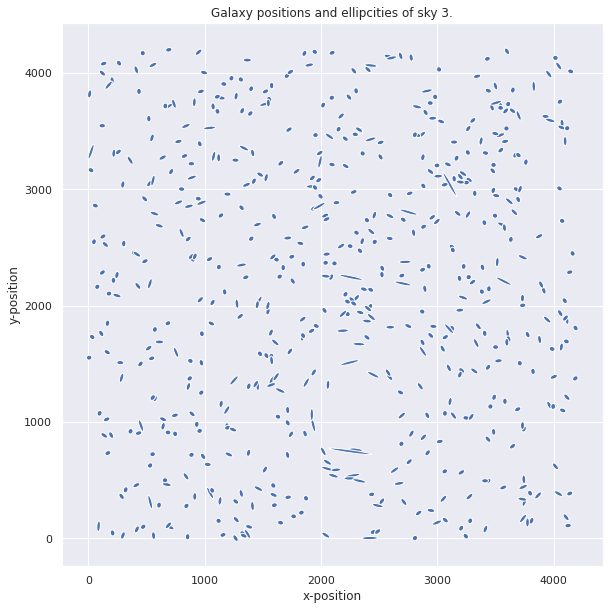

In [18]:
from draw_sky2 import draw_sky
n_sky = 3 #choose a file/sky to examine.
data = np.genfromtxt("data/Train_Skies/Train_Skies/\
Training_Sky%d.csv" % (n_sky),
                      dtype = None,
                      skip_header = 1,
                      delimiter = ",",
                      usecols = [1,2,3,4])
print("Data on galaxies in sky %d."%n_sky)
print("position_x, position_y, e_1, e_2 ")
print(data[:3])

fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position");

In [19]:
def euclidean_distance(x, y):
    return np.sqrt(((x - y)**2)).sum(axis=1)

def f_distance(gxy_pos, halo_pos, c):
    # foo_position should be a 2-d numpy array
    # T.maximum() provides our element-wise maximum as in NumPy, but instead for theano tensors
    return T.maximum(euclidean_distance(gxy_pos, halo_pos), c)[:, None]

def tangential_distance(glxy_position, halo_position):
    # foo_position should be a 2-d numpy array
    delta = glxy_position - halo_position
    t = (2*T.arctan(delta[:,1]/delta[:,0]))
    return T.stack([-T.cos(t), -T.sin(t)], axis=1)


with pm.Model() as model:
    #set the size of the halo's mass
    mass_large = pm.Uniform("mass_large", 40, 180)
    
    #set the initial prior position of the halos, it's a 2-d Uniform dist.
    halo_position = pm.Uniform("halo_position", 0, 4200, shape=(1,2))
    
    mean = pm.Deterministic("mean", mass_large /\
            f_distance(T.as_tensor(data[:,:2]), halo_position, 240)*\
            tangential_distance(T.as_tensor(data[:,:2]), halo_position))
    
    ellpty = pm.Normal("ellipcity", mu=mean, tau=1./0.05, observed=data[:,2:])

In [20]:
with model:
    trace = pm.sample(5000, init='advi', n_init=50000,return_inferencedata=False)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...


Convergence achieved at 25600
INFO:pymc3.variational.inference:Convergence achieved at 25600
Interrupted at 25,599 [51%]: Average Loss = -103.84
INFO:pymc3.variational.inference:Interrupted at 25,599 [51%]: Average Loss = -103.84
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [halo_position, mass_large]
INFO:pymc3:NUTS: [halo_position, mass_large]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 9 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 9 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


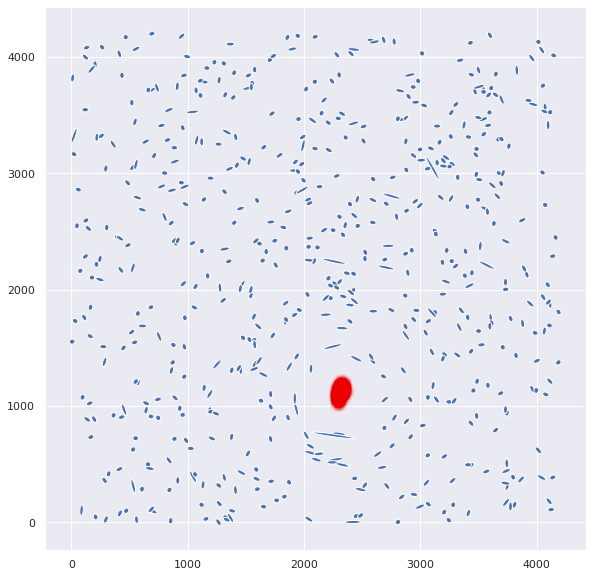

In [21]:
pos=trace["halo_position"].reshape(-1,2)
draw_sky(data)
plt.scatter(pos[:,0],pos[:,1],alpha=0.01,color="red");